In [1]:

import cv2
import os
import numpy as np
import math
import sys

import matplotlib.pyplot as plt

# Get the current working directory and add the src directory to the sys.path
current_dir = os.getcwd()
src_dir = os.path.join(current_dir, '../src/odometry/')
if src_dir not in sys.path:
    sys.path.append(src_dir)

from readcameramodel import readCameraModel
from undistortimage import undistortImage
from imagepreprocessor import ImagePreprocessor

from constants import *

from utils import *

In [2]:
# Reading dataset:

image_processor = ImagePreprocessor(MODEL_DIR)
image_paths = os.listdir(DATA_DIR)
image_paths.sort()
frame_count = 1
for path in image_paths:
    dst_filename = f'{PROCESSED_DATA_DIR}{str(frame_count).zfill(ZERO_PAD)}.png'
    if os.path.exists(dst_filename):
        frame_count += 1
        continue
    image = cv2.imread((DATA_DIR + path), 0)
    processed_img = image_processor.process_image(image)
    cv2.imwrite(dst_filename, processed_img)
    frame_count += 1
    
    # Initial images are oversaturated, it is ok
    # Plot the original image
    # plt.subplot(1, 2, 1)
    # plt.imshow(image, cmap='gray')
    # plt.title('Original Image')

    # # Plot the processed image
    # plt.subplot(1, 2, 2)
    # plt.imshow(processed_img, cmap='gray')
    # plt.title('Processed Image')

    # # Display the plot
    # plt.show()
    
    # break
print('Done!!')

Done!!


In [3]:
print(frame_count)

3874


# Visual odometry (builtin)

In [4]:
# from motionestimator_inbuilt import load_features, load_poses, extract_features, read_image
# import time
# import numpy as np
# import json
# from motionestimator_inbuilt import NumpyArrayEncoder

# # def estimate_camera_motion():
# K = image_processor.intrinsic_camrera_matrix

# features = load_features()
# pre_calc_poses = load_poses()

# frame_count = 0
# init_point = np.array([0, 0, 0, 1])
# H = np.eye(4)
# t = np.array([0, 0, 0]).reshape(3,1)
# R = np.eye(3)

# camera_pose = np.eye(4)

# ESTIMATION_METHOD = 'INBUILT'
# start = time.perf_counter()
# while True:
#     frame1 = read_image(INIT_IMAGE + frame_count)
#     frame2 = read_image(INIT_IMAGE + frame_count + 1)

#     if (frame1 is None) or (frame2 is None) or (cv2.waitKey(1) == 27):
#         break
    
#     frame_name = str(INIT_IMAGE + frame_count)

#     pose = pre_calc_poses.get(frame_name)

#     if pose is None:

#         features1, features2 = extract_features(frame1, frame2, features, frame_name)
#         essential_mat, _ = cv2.findEssentialMat(features1[:, :COL3], features2[:, :COL3], focal=K[ROW1, COL1], pp=(K[ROW1, COL3], K[ROW2, COL3]), method=cv2.RANSAC, prob=0.999, threshold=0.5)
#         _, new_R, new_t, mask = cv2.recoverPose(essential_mat, features1[:, :COL3], features2[:, :COL3], K)
#         if np.linalg.det(new_R) < 0:
#             new_R = -new_R
#             new_t = -new_t
#         pre_calc_poses[frame_name] = list(np.column_stack((new_R, new_t)))

#         with open(POSE_FILE, 'w') as pose_file:
#             json.dump(pre_calc_poses, pose_file, cls=NumpyArrayEncoder)
#     else:
#         pose = np.asarray(pose)
#         new_R = pose[:, :COL4]
#         new_t = pose[:, COL4].reshape(3,1)


#     new_pose = np.column_stack((new_R, new_t))
#     new_pose = np.vstack((new_pose, np.array([0,0,0,1])))

#     camera_pose = camera_pose @ new_pose
#     x_coord = camera_pose[ROW1, -1]
#     z_coord = camera_pose[ROW3, -1]

#     print('\n\nframe_count', frame_count, frame_name)
#     print('\n\nTime taken: ', (time.perf_counter() - start))

#     plt.scatter(x_coord, -z_coord, color='b') 
#     plt.pause(0.00001)

#     plt.savefig(PLOT_FILE_PATH.format(ESTIMATION_METHOD, frame_name.zfill(ZERO_PAD)), bbox_inches='tight')
    
#     frm = cv2.resize(frame1, (0,0), fx=0.5, fy=0.5)
#     cv2.imshow('Frame', frm)
    
#     frame_count += 1

#     if INIT_IMAGE + frame_count == STOP_IMAGE:
#        break

# cv2.destroyAllWindows()
# plt.show()


## Visual odometry BUILTIN2

In [5]:
from motionestimator import *

use_cached_features = False
use_cached_poses = False

init_point = np.array([0, 0, 0, 1])
H = np.eye(4)
t = np.array([0, 0, 0]).reshape(3,1)
R = np.eye(3)
camera_pose = np.eye(4)

ESTIMATION_METHOD = 'INBUILT_POSE_SELF'
start = time.perf_counter()

K = image_processor.intrinsic_camrera_matrix

features = None
if use_cached_features:
    features = load_features()
pre_calc_poses = None
if use_cached_poses:
    pre_calc_poses = load_poses()

In [6]:
frame_count = 0

In [7]:
frame1_name = str(INIT_IMAGE + frame_count)
frame2_name = str(INIT_IMAGE + frame_count + 1)
frame1 = read_image(INIT_IMAGE + frame_count)
frame2 = read_image(INIT_IMAGE + frame_count + 1)

if (frame1 is None) or (frame2 is None) or (cv2.waitKey(1) == 27):
    throw('Error reading images')

frame_name = str(INIT_IMAGE + frame_count)

pose = None
if pre_calc_poses is not None:
    pose = pre_calc_poses.get(frame_name)
    if pose is not None:
        pose = np.asarray(pose)
        new_R = pose[:, :COL4]
        new_t = pose[:, COL4].reshape(3,1)


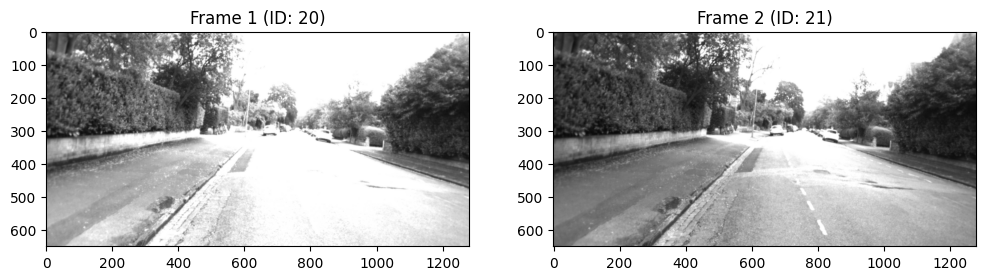

In [8]:
display_plot = True
if display_plot:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Increase the size of the figure

    axes[0].imshow(frame1, cmap='gray')
    axes[0].set_title(f'Frame 1 (ID: {frame1_name})')  # Add the ID of the image to the title

    axes[1].imshow(frame2, cmap='gray')
    axes[1].set_title(f'Frame 2 (ID: {frame2_name})')  # Add the ID of the image to the title

    plt.show()


In [9]:
def get_cached_features(features_cache, frame_name):
    features1 = features_cache.get(frame_name).get('features1')
    features2 = features_cache.get(frame_name).get('features2')
    
    features1 = np.array(features1)
    features2 = np.array(features2)

    # TODO: check if those has to be of identical length, feels like a bug
    ind1 = np.where(features1[:, 1] > CROP_MIN)
    features1 = features1[ind1]
    features2 = features2[ind1] # TODO: feels like a bug

    ind2 = np.where(features2[:, 1] > CROP_MIN)
    features1 = features1[ind2]
    features2 = features2[ind2]

    features1[:, 1] = features1[:, 1] - CROP_MIN
    features2[:, 1] = features2[:, 1] - CROP_MIN

    features1 = np.ascontiguousarray(features1)
    features2 = np.ascontiguousarray(features2)
    return features1, features2

In [19]:
def compute_features(frame1, frame2, frame_name):
    features1 = []
    features2 = []

    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # find the keypoints and descriptors with SIFT
    keypoint1, descriptor1 = sift.detectAndCompute(frame1, mask=None)
    keypoint2, descriptor2 = sift.detectAndCompute(frame2, mask=None)

    # Draw keypoints on the image
    # Display the image with keypoints
    detailed_vis = False
    if detailed_vis:
        image_with_keypoints = cv2.drawKeypoints(frame1, keypoint1, outImage=None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        cv2.imshow('SIFT Keypoints', image_with_keypoints)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # TODO: (dkushn) ammend with RANSAC-based matching?
    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptor1, descriptor2, k=2)
    
    # ratio test as per Lowe's paper
    good_matches = []
    for i, (top1, top2) in enumerate(matches):
        if top1.distance < 0.8*top2.distance:
        # if top1.distance < 1.0*top2.distance: # === for the intentionally bad filtering
            x1, y1 = keypoint1[top1.queryIdx].pt
            x2, y2 = keypoint2[top1.trainIdx].pt
            features1.append([x1, y1, 1])
            features2.append([x2, y2, 1])
            good_matches.append(top1)

    display_matches = False
    if display_matches:
        image_matches = cv2.drawMatches(frame1, keypoint1,
                                        frame2, keypoint2,
                                        matches,
                                            outImg=None, 
                                        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        # Display the image with matches
        cv2.imshow('Matches', image_matches)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    write_to_file(features1, features2, frame_name)

    features1 = np.ascontiguousarray(features1)
    features2 = np.ascontiguousarray(features2)

    return features1, features2

In [20]:
features_cache = features
if features_cache is not None and features_cache.get(frame_name) is not None:
    features1, features2 = get_cached_features(features_cache, frame_name)
else:
    features1, features2 = compute_features(frame1, frame2, frame_name)

# Full trajectory pipeline:



frame_count 0 20


Time taken:  4.434732161999818


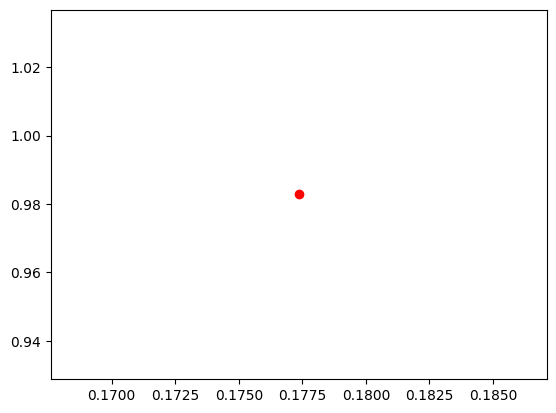



frame_count 1 21


Time taken:  9.527875940999365


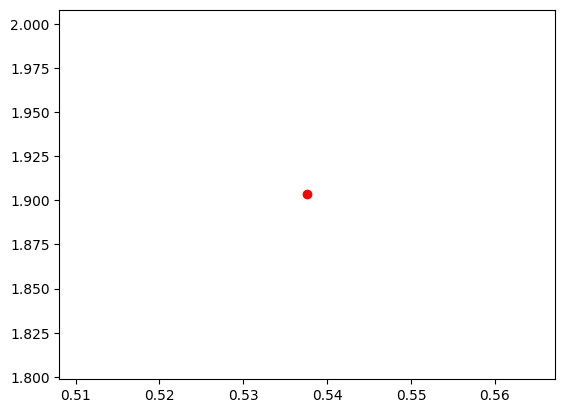



frame_count 2 22


Time taken:  15.225043220999396


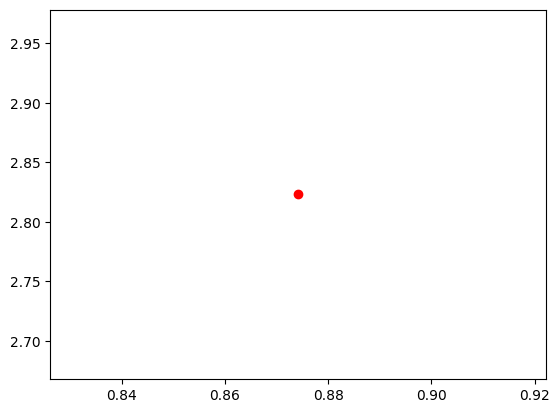



frame_count 3 23


Time taken:  19.463950246999957


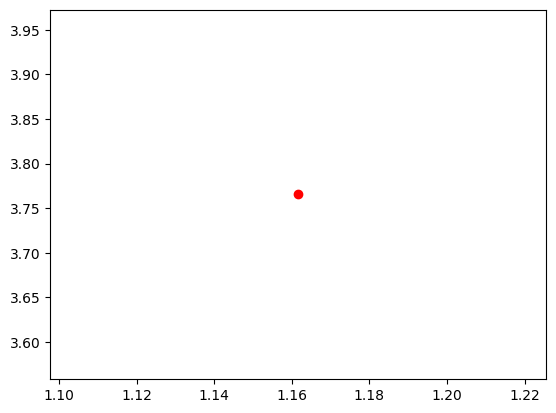



frame_count 4 24


Time taken:  24.09029647099942


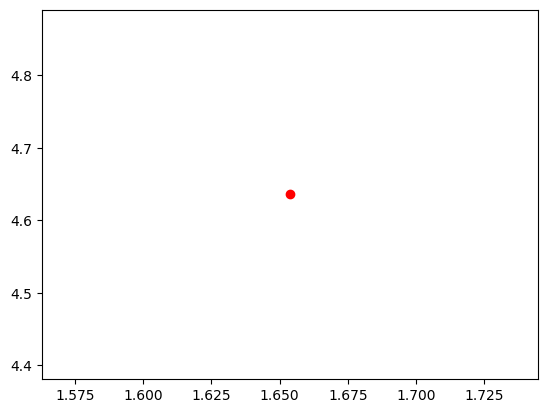



frame_count 5 25


Time taken:  28.701902066000002


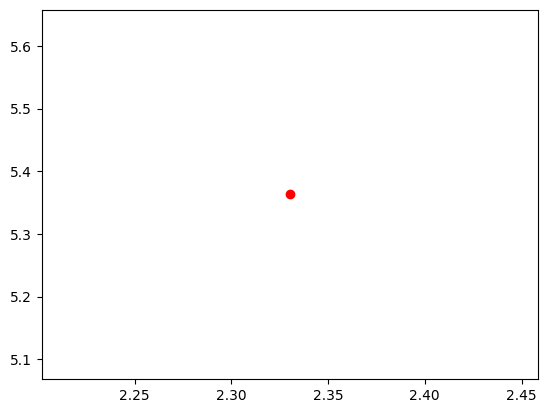



frame_count 6 26


Time taken:  33.11053709999942


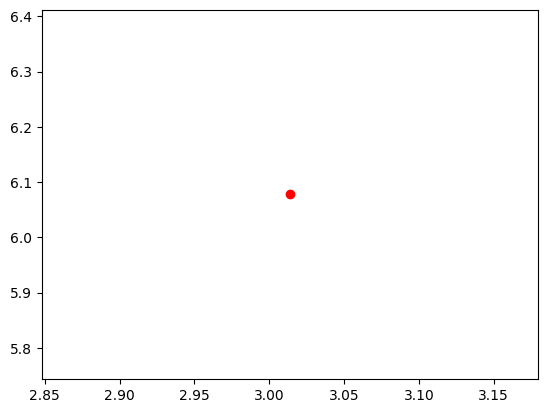



frame_count 7 27


Time taken:  37.55508189899956


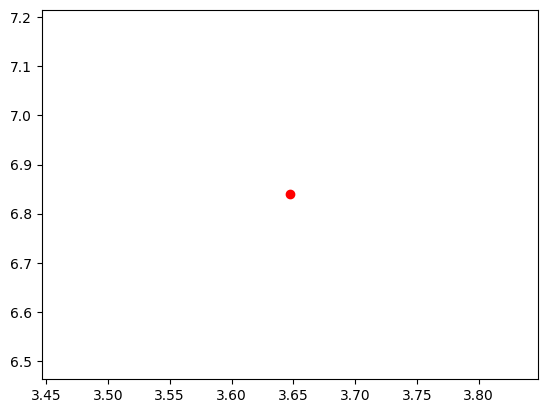



frame_count 8 28


Time taken:  41.92699462600012


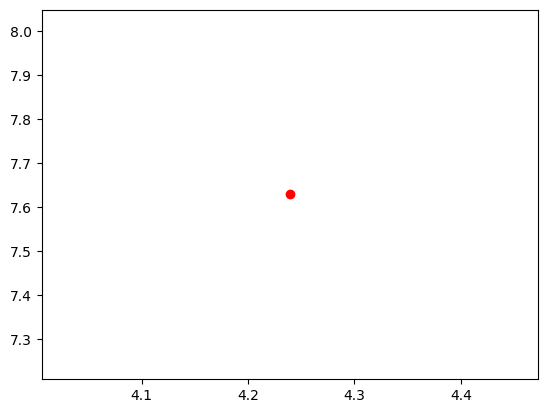



frame_count 9 29


Time taken:  46.30644393300008


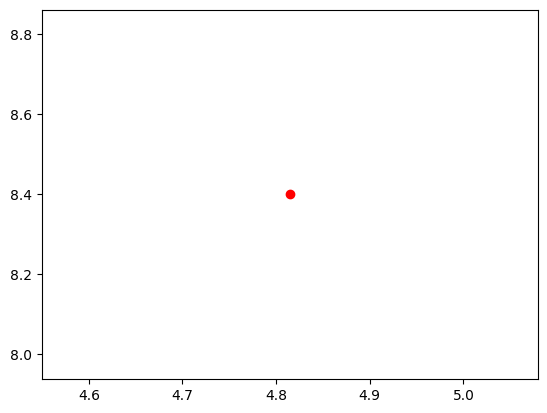



frame_count 10 30


Time taken:  50.763482203999956


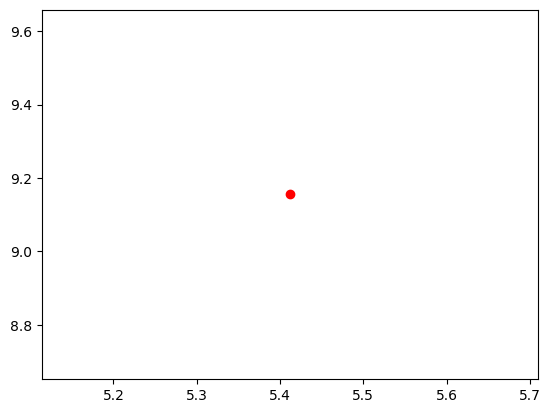

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ac6ecbe2620>>
Traceback (most recent call last):
  File "/home/dkushn/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 




frame_count 11 31


Time taken:  55.52277920799952


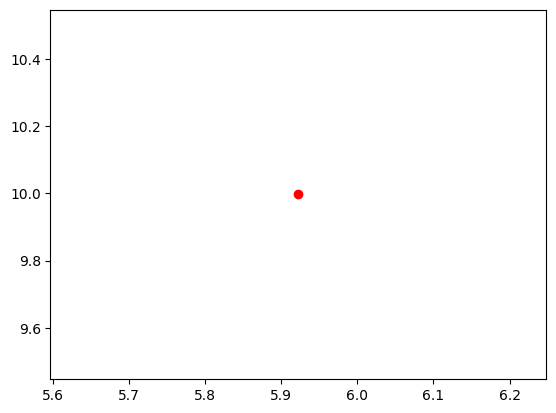



frame_count 12 32


Time taken:  60.17293021799924


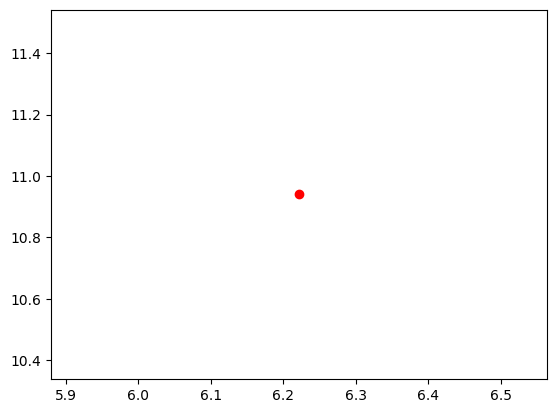



frame_count 13 33


Time taken:  70.23901675499928


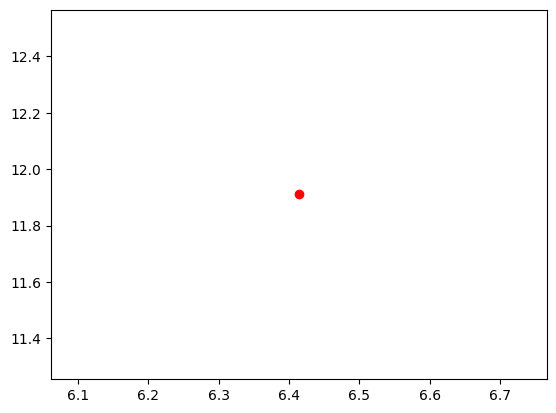



frame_count 14 34


Time taken:  74.60212360399964


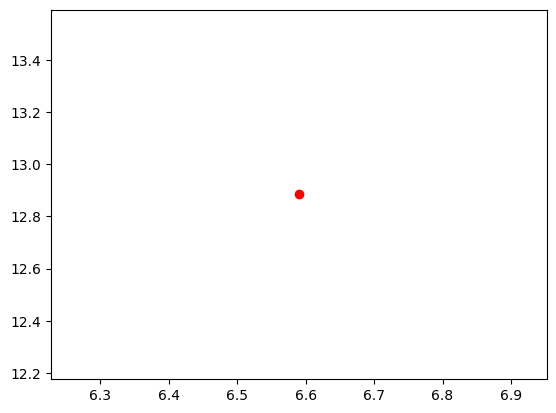



frame_count 15 35


Time taken:  78.8685980149994


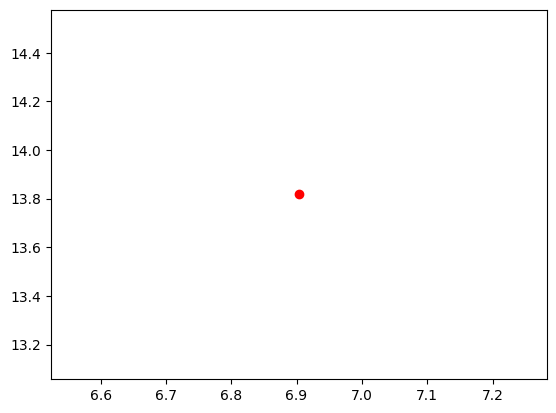



frame_count 16 36


Time taken:  82.9807360169998


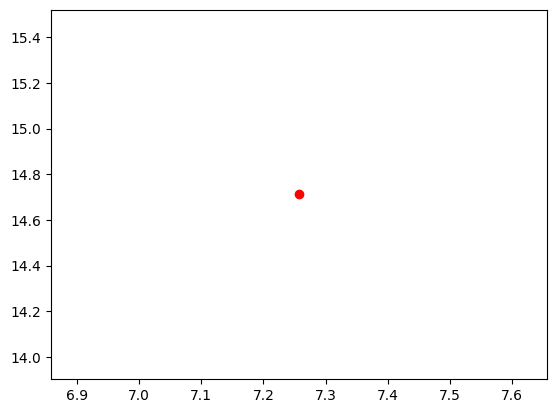



frame_count 17 37


Time taken:  87.08833206799954


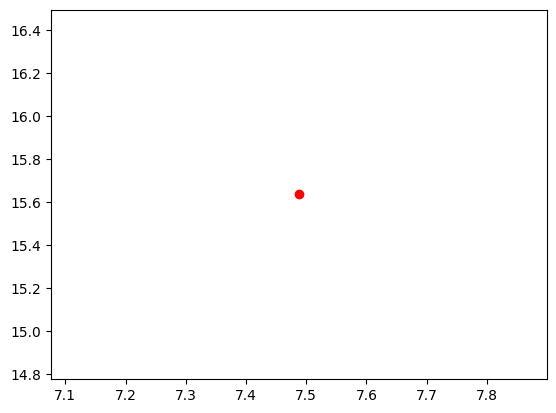



frame_count 18 38


Time taken:  91.20170299999972


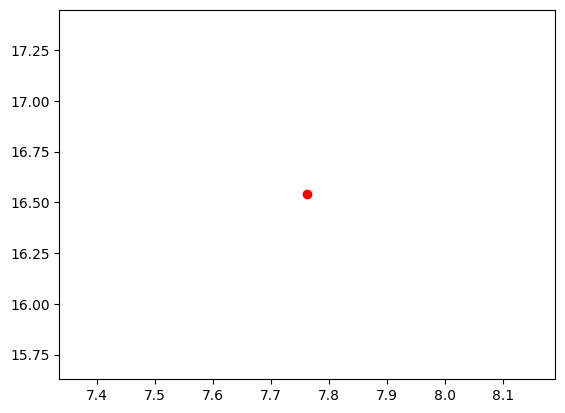



frame_count 19 39


Time taken:  95.4923916709995


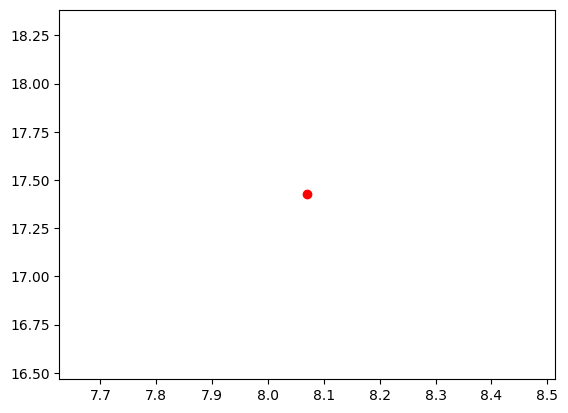



frame_count 20 40


Time taken:  99.8935814739998


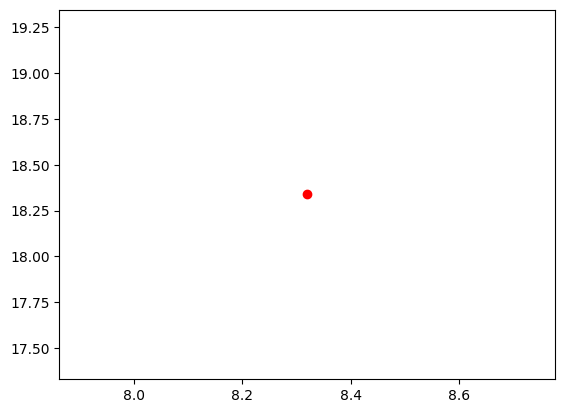



frame_count 21 41


Time taken:  104.56017812499977


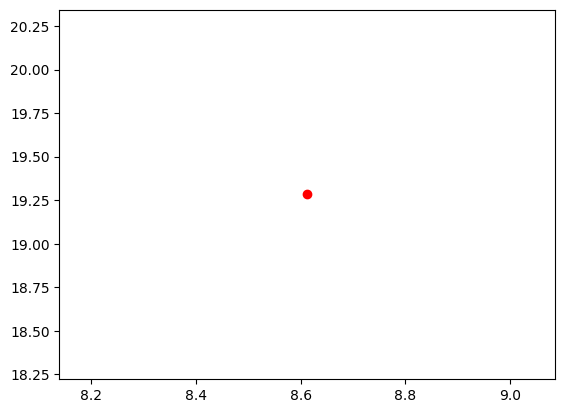



frame_count 22 42


Time taken:  109.0658016339994


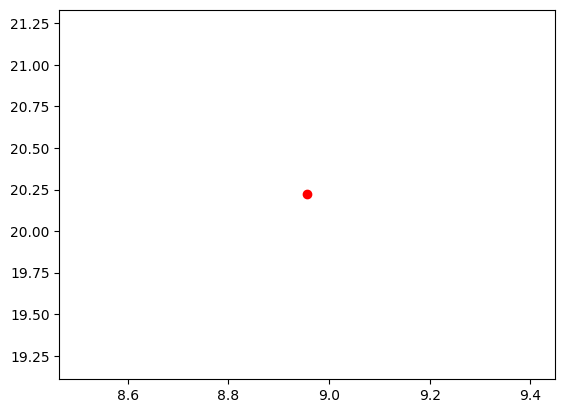



frame_count 23 43


Time taken:  113.5548135909994


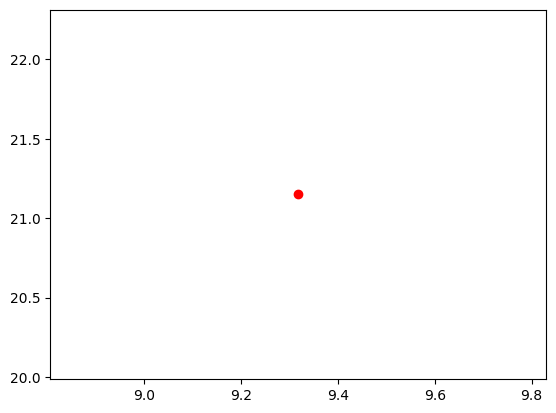



frame_count 24 44


Time taken:  118.08147958999962


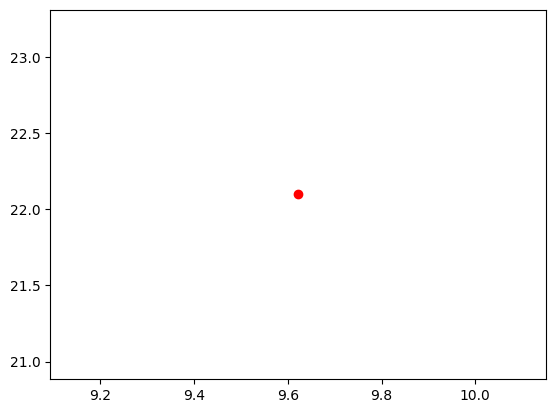



frame_count 25 45


Time taken:  122.74483734799924


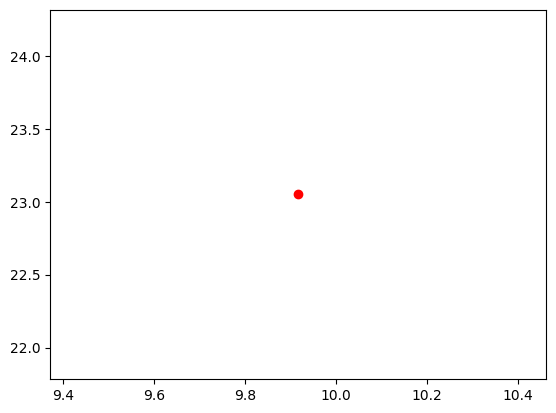



frame_count 26 46


Time taken:  127.5859268919994


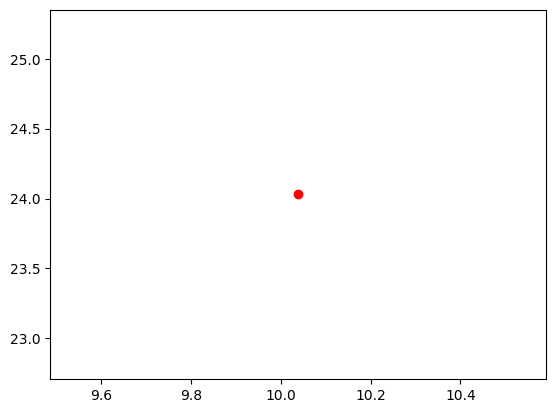



frame_count 27 47


Time taken:  132.5960123469995


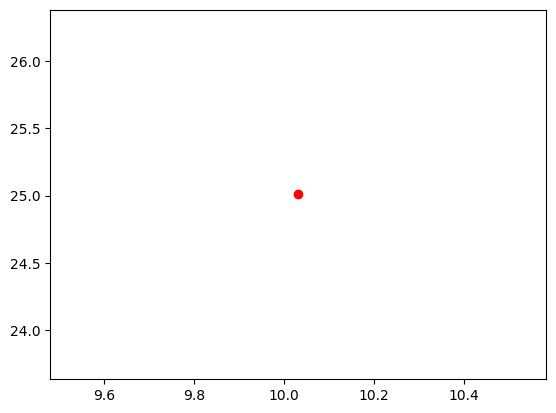



frame_count 28 48


Time taken:  137.66459611999926


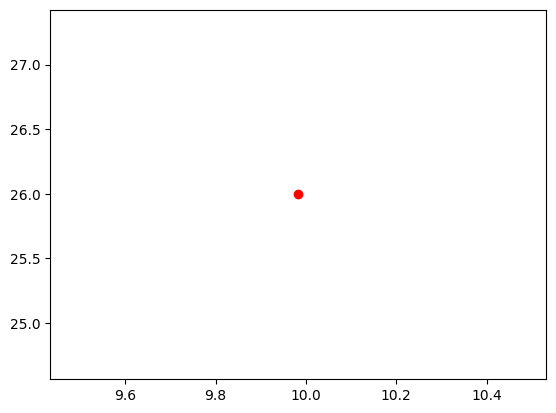



frame_count 29 49


Time taken:  142.72489881399997


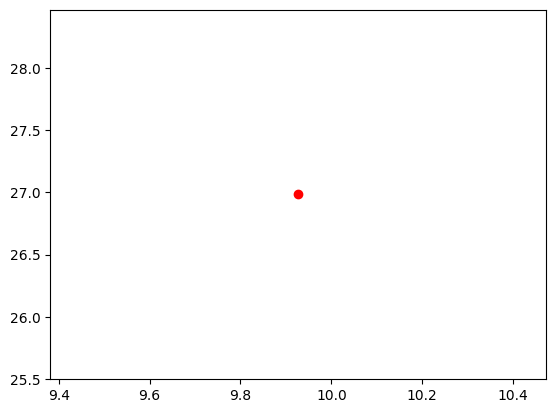



frame_count 30 50


Time taken:  147.89568918699933


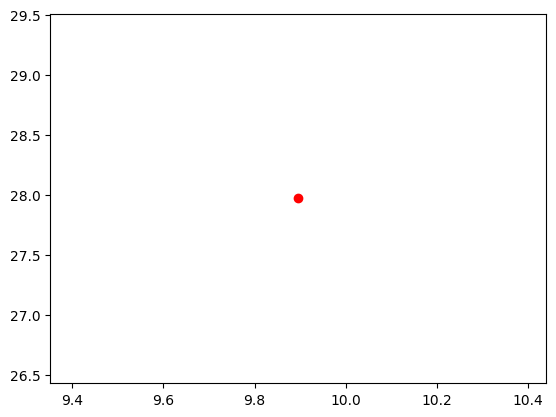



frame_count 31 51


Time taken:  152.9933137449998


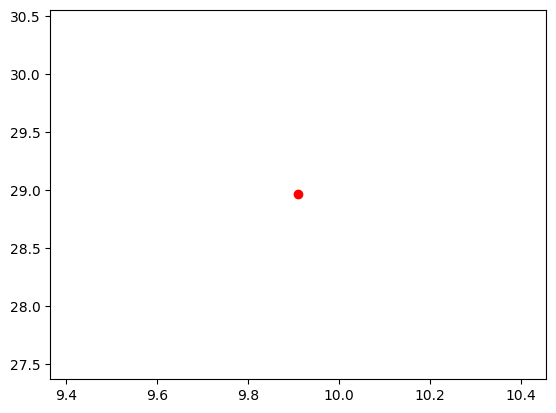



frame_count 32 52


Time taken:  157.92095447700012


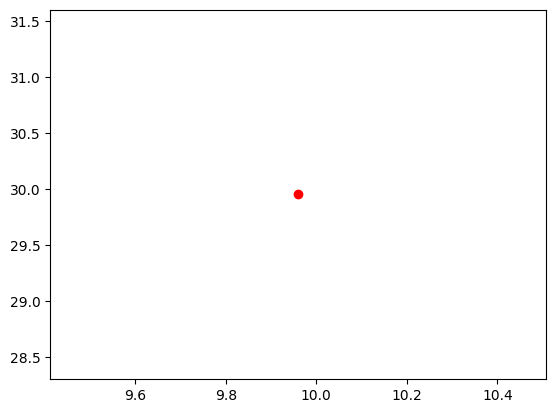



frame_count 33 53


Time taken:  163.19864364399928


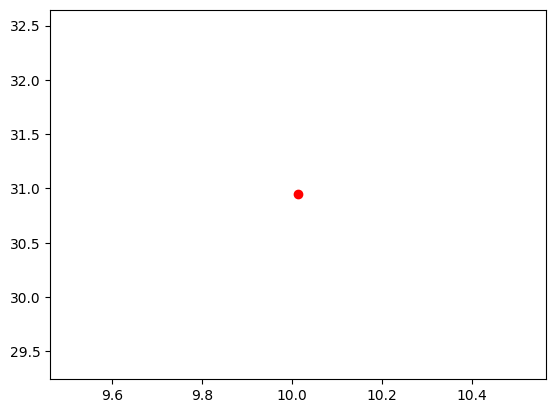



frame_count 34 54


Time taken:  168.2482965449999


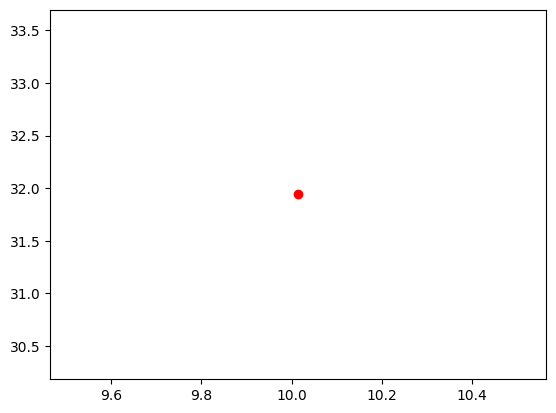



frame_count 35 55


Time taken:  173.36211261500011


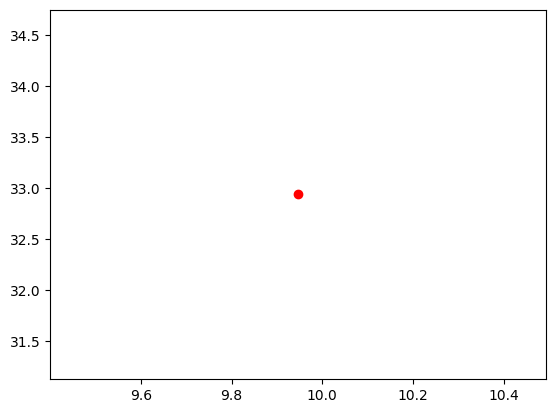



frame_count 36 56


Time taken:  179.25739997299934


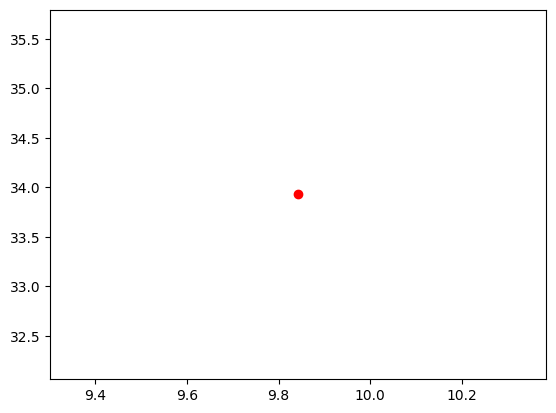



frame_count 37 57


Time taken:  182.83380101199964


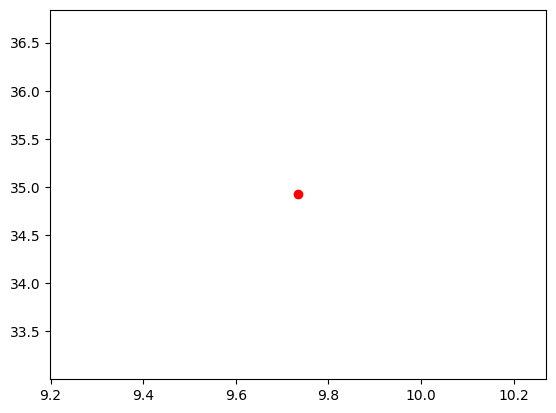



frame_count 38 58


Time taken:  186.56589332599924


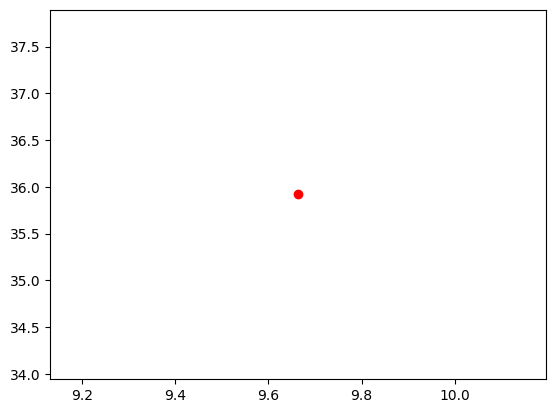



frame_count 39 59


Time taken:  190.36410653699932


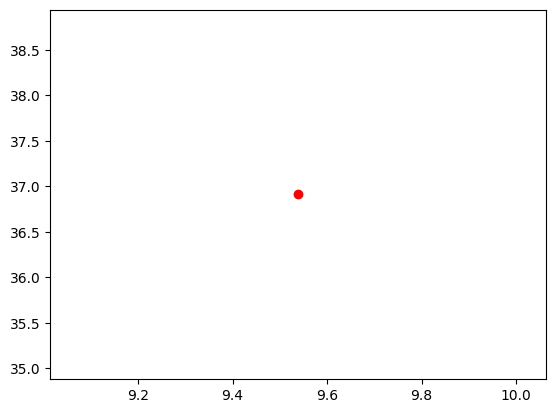



frame_count 40 60


Time taken:  194.0965094409994


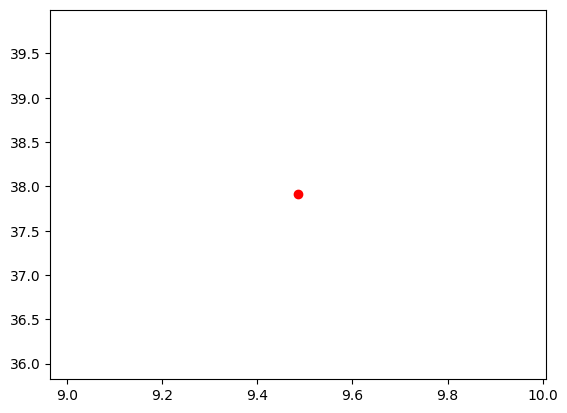



frame_count 41 61


Time taken:  197.88066465199972


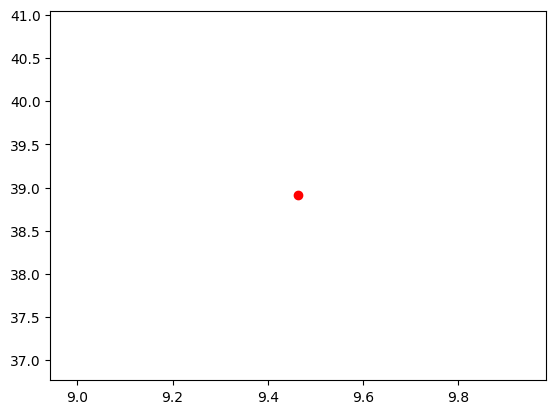



frame_count 42 62


Time taken:  204.21941836599945


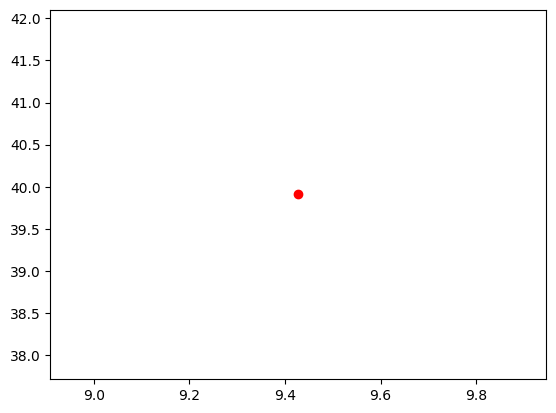



frame_count 43 63


Time taken:  207.8877307189996


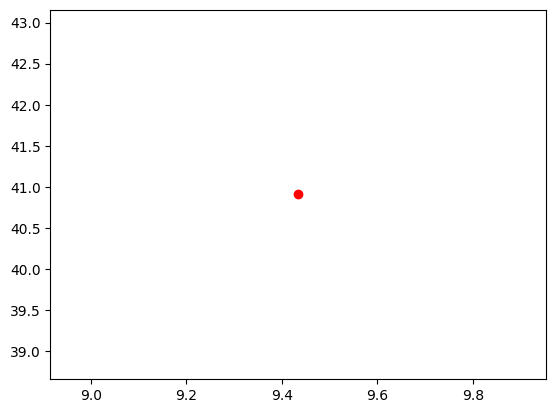



frame_count 44 64


Time taken:  211.5825347709997


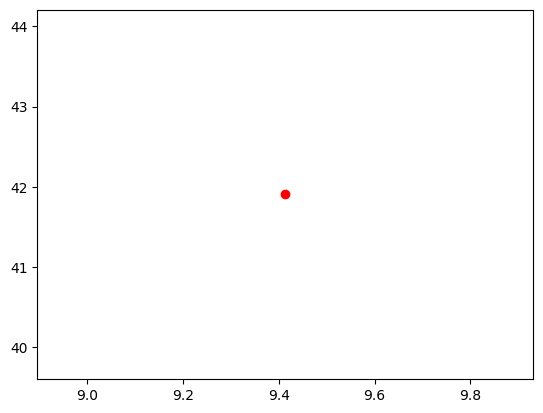



frame_count 45 65


Time taken:  215.35129307899933


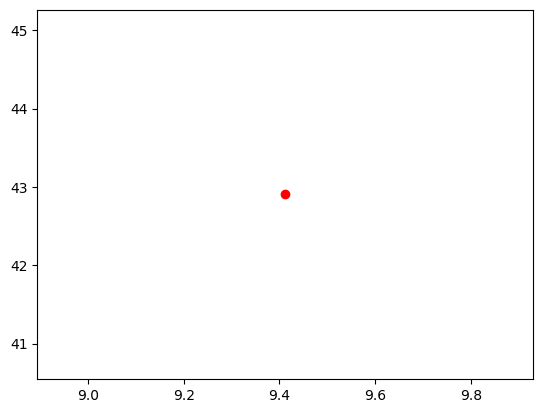



frame_count 46 66


Time taken:  219.166564827


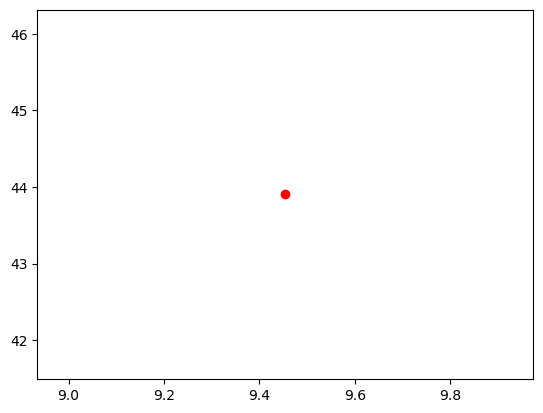



frame_count 47 67


Time taken:  222.8172680130001


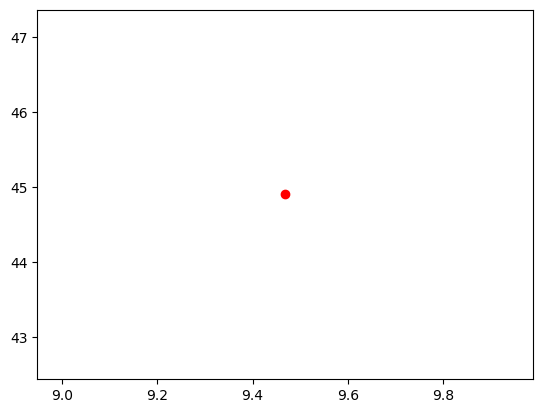



frame_count 48 68


Time taken:  226.4068806360001


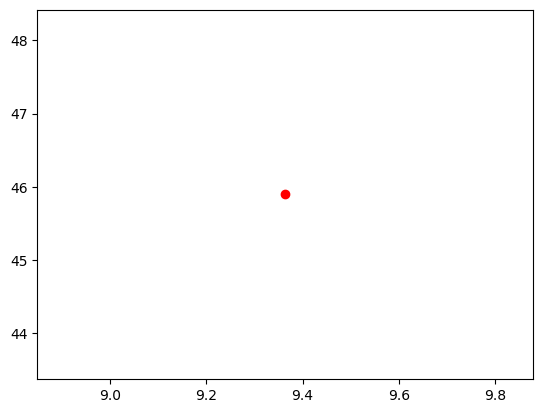



frame_count 49 69


Time taken:  230.01446694100014


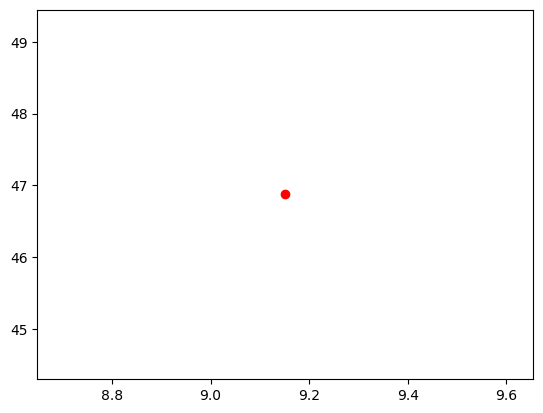



frame_count 50 70


Time taken:  233.49495391999972


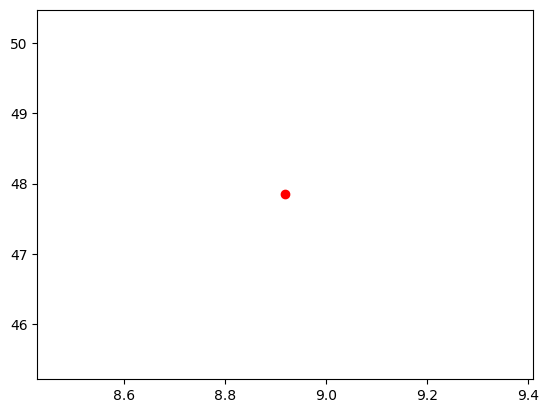



frame_count 51 71


Time taken:  237.05461038700014


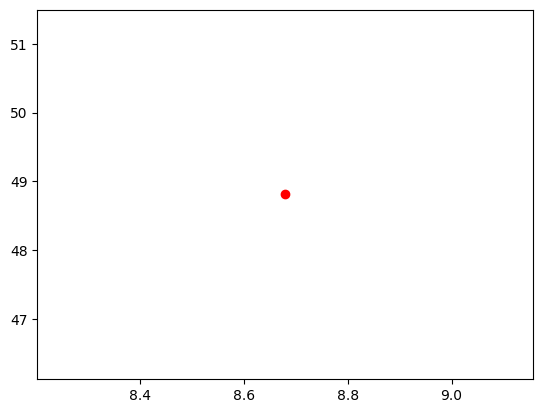



frame_count 52 72


Time taken:  240.63552150899977


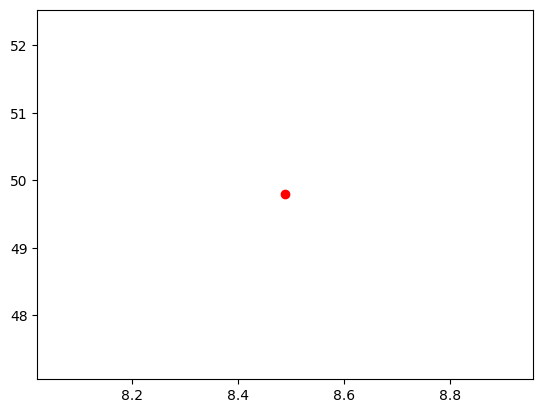



frame_count 53 73


Time taken:  244.16064228300002


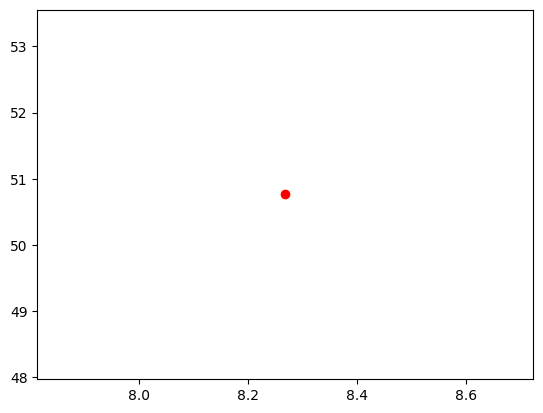



frame_count 54 74


Time taken:  247.8782609709997


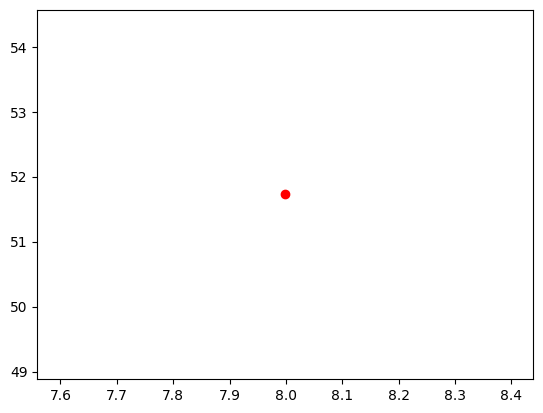



frame_count 55 75


Time taken:  251.33931848999964


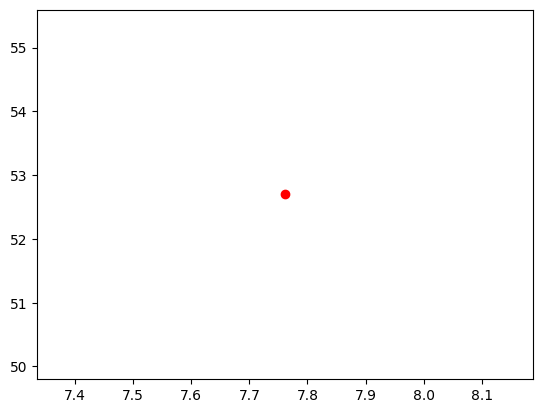



frame_count 56 76


Time taken:  259.97136503899947


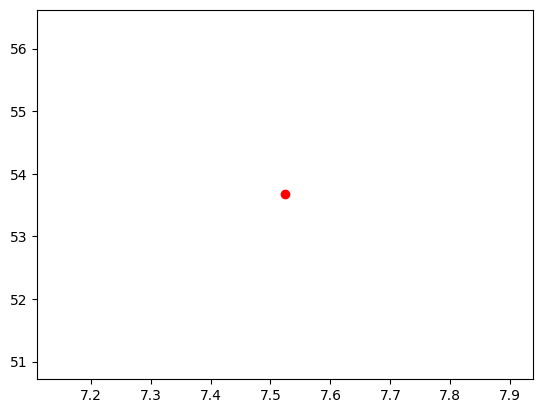



frame_count 57 77


Time taken:  263.50511704699966


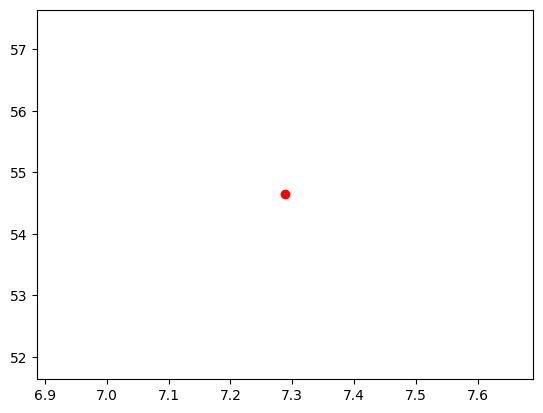



frame_count 58 78


Time taken:  267.37291262599956


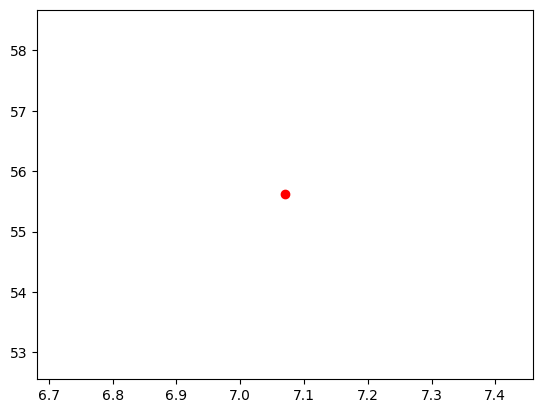



frame_count 59 79


Time taken:  271.3826577239997


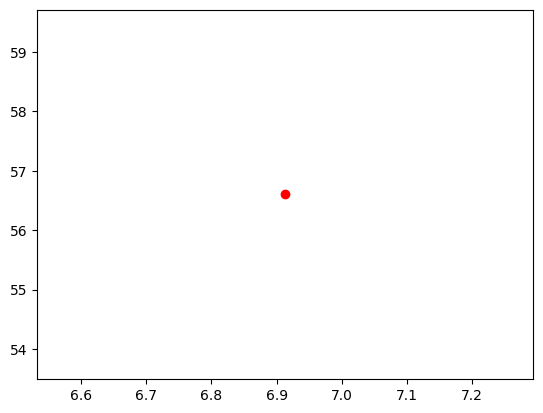



frame_count 60 80


Time taken:  275.3060159639999


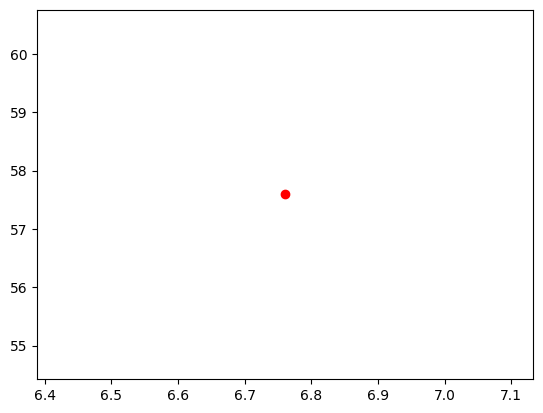



frame_count 61 81


Time taken:  279.2521497029993


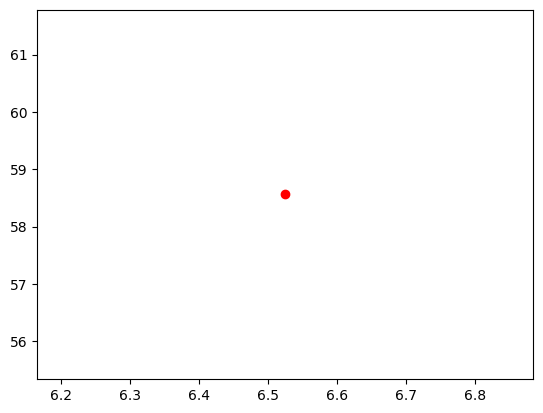



frame_count 62 82


Time taken:  282.92028198999924


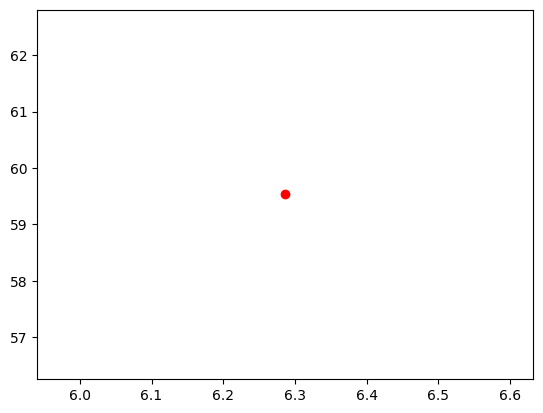



frame_count 63 83


Time taken:  286.8549106119999


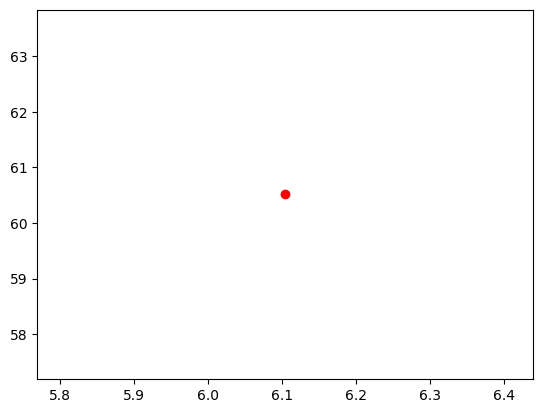



frame_count 64 84


Time taken:  290.94180073499956


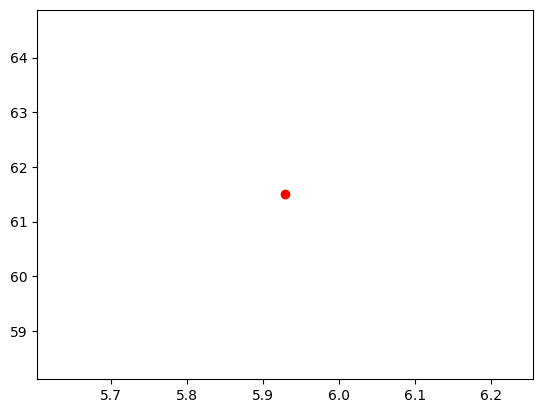



frame_count 65 85


Time taken:  295.0563995379998


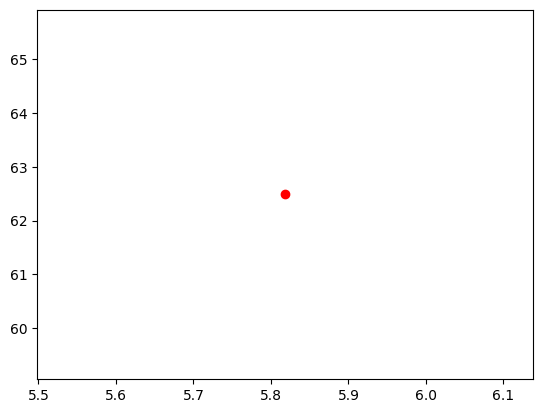



frame_count 66 86


Time taken:  303.61411157099974


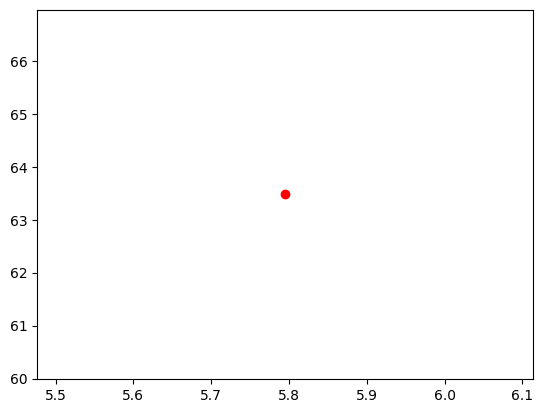



frame_count 67 87


Time taken:  309.61004792199947


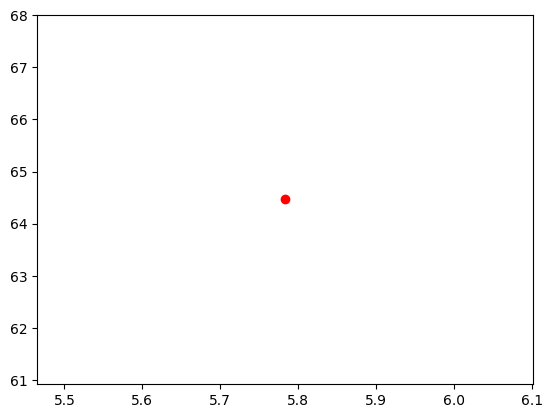



frame_count 68 88


Time taken:  313.4608237759994


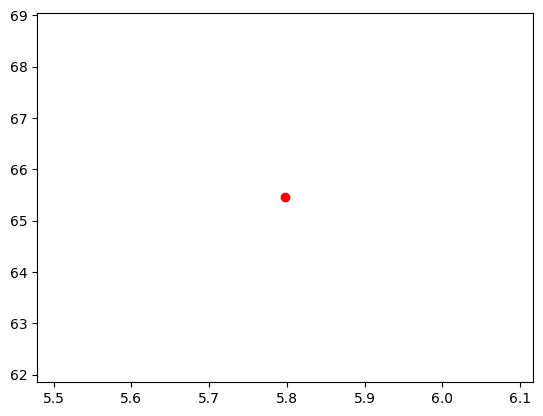



frame_count 69 89


Time taken:  317.46847959799925


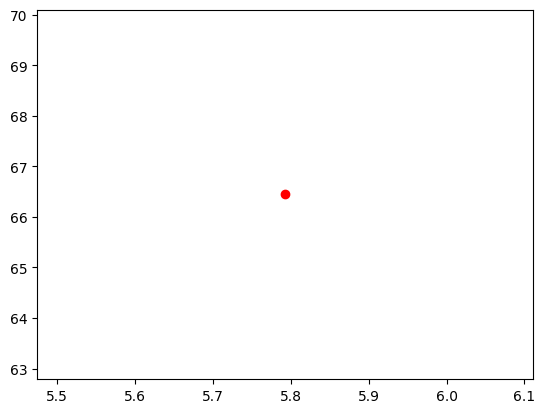



frame_count 70 90


Time taken:  321.440720994


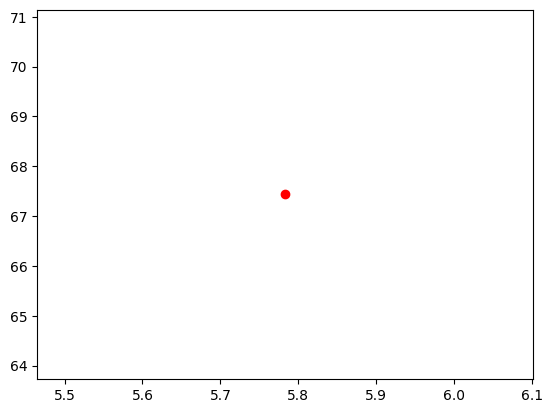



frame_count 71 91


Time taken:  325.3476015639999


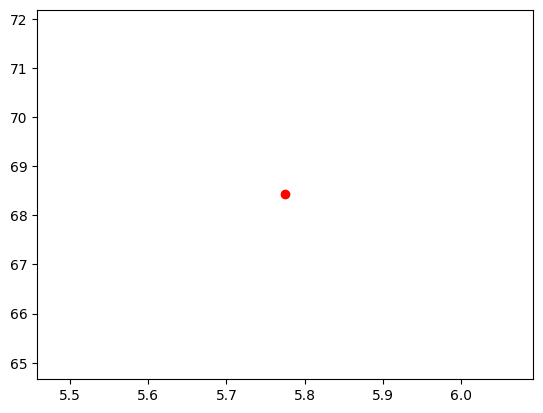



frame_count 72 92


Time taken:  329.45290907099934


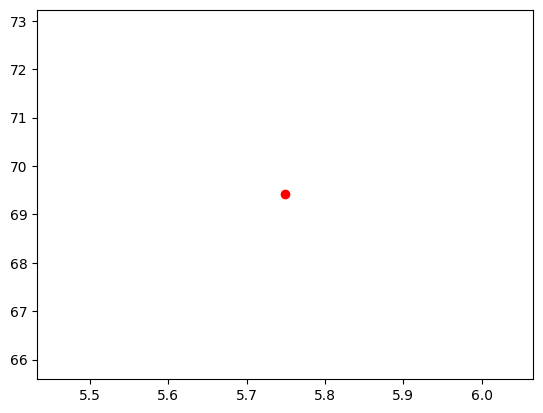



frame_count 73 93


Time taken:  333.61562966399924


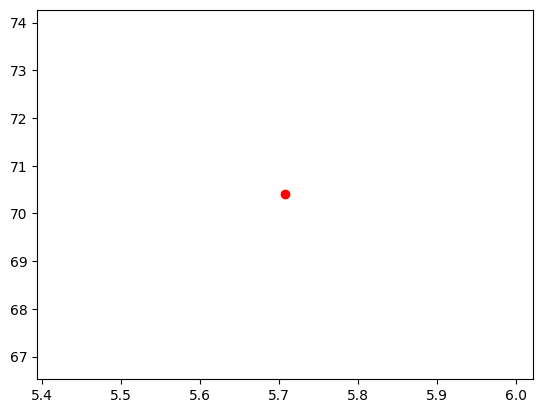



frame_count 74 94


Time taken:  337.71459805999984


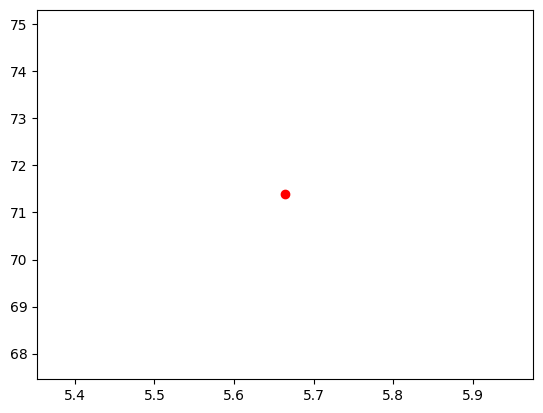



frame_count 75 95


Time taken:  341.99830710199967


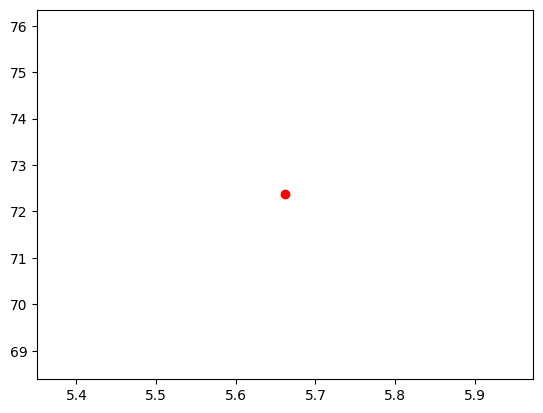



frame_count 76 96


Time taken:  346.28635135700006


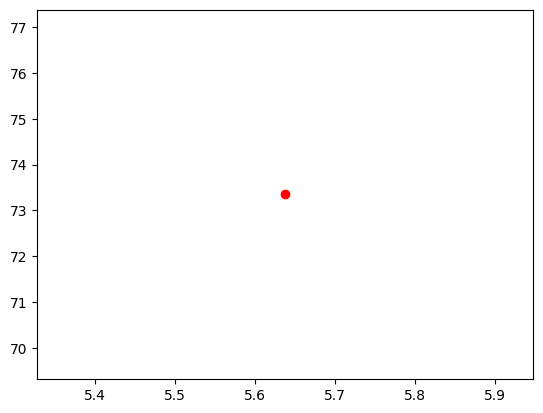



frame_count 77 97


Time taken:  350.7698099449999


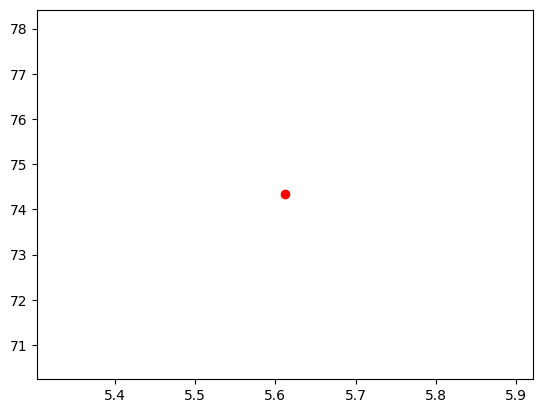



frame_count 78 98


Time taken:  355.4158965159995


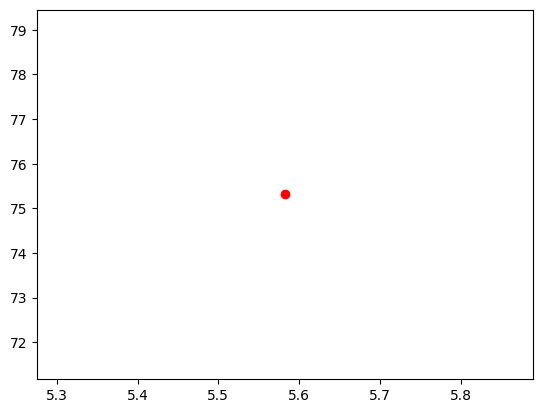



frame_count 79 99


Time taken:  360.0676257159994


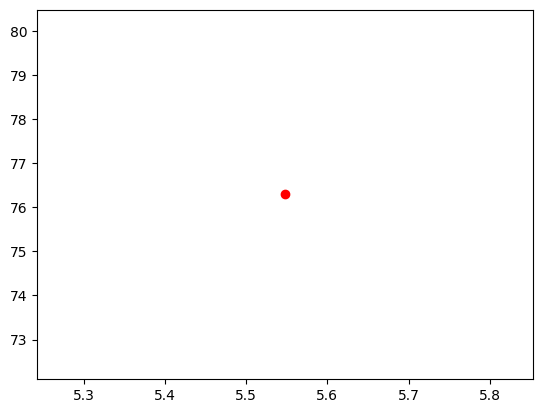



frame_count 80 100


Time taken:  364.885962501


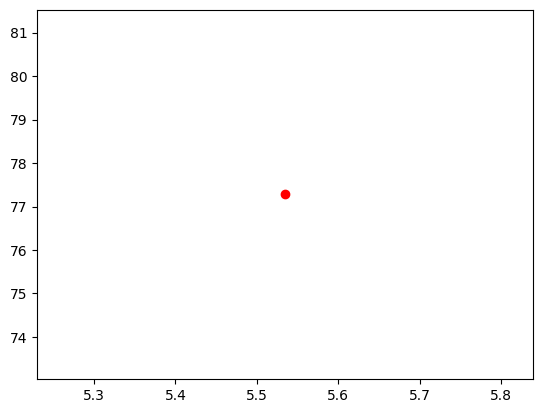



frame_count 81 101


Time taken:  369.71452770499945


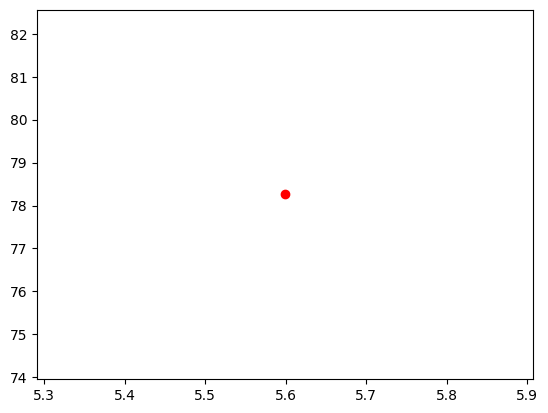

In [ ]:
from motionestimator import *

K = image_processor.intrinsic_camrera_matrix

features = None
if use_cached_features:
    features = load_features()
poses = None
if use_cached_poses:
    pre_calc_poses = load_poses()


init_point = np.array([0, 0, 0, 1])
H = np.eye(4)
t = np.array([0, 0, 0]).reshape(3,1)
R = np.eye(3)
camera_pose = np.eye(4)


use_openCV_pose = True
ESTIMATION_METHOD = 'INBUILT_POSE_SELF'
if use_openCV_pose:
    ESTIMATION_METHOD = 'INBUILT'

start = time.perf_counter()

# TODO: (dkushn) refactor this, replace with functsion calls

frame_count = 0
while True:
    frame1 = read_image(INIT_IMAGE + frame_count)
    frame2 = read_image(INIT_IMAGE + frame_count + 1)

    if (frame1 is None) or (frame2 is None) or (cv2.waitKey(1) == 27):
        break
    
    frame_name = str(INIT_IMAGE + frame_count)

    pose = None
    if pre_calc_poses is not None:
        pose = pre_calc_poses.get(frame_name)
        if pose is not None:
            pose = np.asarray(pose)
            new_R = pose[:, :COL4]
            new_t = pose[:, COL4].reshape(3,1)

    # if cache is not available:
    if pose is None:
        if features_cache is not None and features_cache.get(frame_name) is not None:
            features1, features2 = get_cached_features(features_cache, frame_name)
        else:
            features1, features2 = compute_features(frame1, frame2, frame_name)

        if use_openCV_pose:
            essential_mat, _ = cv2.findEssentialMat(features1[:, :COL3],
                                                     features2[:, :COL3],
                                                       focal=K[ROW1, COL1], 
                                                       pp=(K[ROW1, COL3], K[ROW2, COL3]), 
                                                       method=cv2.RANSAC, prob=0.999, threshold=0.5)
            _, new_R, new_t, mask = cv2.recoverPose(essential_mat, features1[:, :COL3], features2[:, :COL3], K)
            if np.linalg.det(new_R) < 0:
                new_R = -new_R
                new_t = -new_t
            pre_calc_poses[frame_name] = list(np.column_stack((new_R, new_t)))
                    
        else:
            fundamental_matrix, point_list1, point_list2 = fundmntl_mat_from_8_point_ransac(features1, features2)
            essential_mat = calc_essential_matrix(K, fundamental_matrix)
            poses = get_possible_camera_poses(essential_mat)
            pose = get_correct_pose(poses, point_list1, point_list2, non_linear_flag=False)
            new_R = pose[:, :COL4]
            new_t = pose[:, COL4].reshape(3,1)
            pre_calc_poses[frame_name] = list(pose)

        
        with open(POSE_FILE, 'w') as pose_file:
            json.dump(pre_calc_poses, pose_file, cls=NumpyArrayEncoder)
            

    new_pose = np.column_stack((new_R, new_t))
    new_pose = np.vstack((new_pose, np.array([0,0,0,1])))

    camera_pose = camera_pose @ new_pose
    x_coord = camera_pose[ROW1, -1]
    z_coord = camera_pose[ROW3, -1]

    print('\n\nframe_count', frame_count, frame_name)
    print('\n\nTime taken: ', (time.perf_counter() - start))

    plt.scatter(x_coord, -z_coord, color='r') 
    plt.pause(0.00001)

    plt.savefig(PLOT_FILE_PATH.format(ESTIMATION_METHOD, frame_name.zfill(ZERO_PAD)), bbox_inches='tight')
    
    frm = cv2.resize(frame1, (0,0), fx=0.5, fy=0.5)
    cv2.imshow('Frame', frm)
    
    frame_count += 1

    if INIT_IMAGE + frame_count == STOP_IMAGE:
       break

cv2.destroyAllWindows()
plt.show()